# TASK 8

### Team Task


Object Recognition using CNN model
<br><br>
Task Description 📄

📌 In this task :<br>
👉Create a model that will detect a car and recognize characters on number plate of the car .<br>
👉Secondly , it will use the characters and fetch the owners information using RTO API’s .<br>
👉Create a Web portal where all this information will be displayed (using html,css,and js)<br><br><br>

##  Import Required Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# For Machine Learning model:

import keras.backend as K
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

# For API Call:

import requests
import xmltodict
import json

## Funtion for detecting the number plate of a car

In [2]:
# detecting license plate on the vehicle
plateCascade = cv2.CascadeClassifier('indian_license_plate.xml')

In [3]:
# detect the plate
def plate_detect(img):
    plateImg = img.copy()
    roi = img.copy()
    plateRect = plateCascade.detectMultiScale(plateImg, scaleFactor = 1.2775, minNeighbors = 6)
    for (x,y,w,h) in plateRect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate_part = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plateImg,(x+2,y),(x+w-3, y+h-5),(0,255,0),3)
    return plateImg, plate_part

In [4]:
#normal function to display 
def display_img(img):
    img_ = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img_)
    plt.show()

## Select the car image

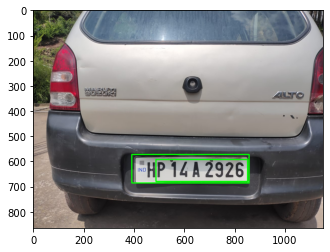

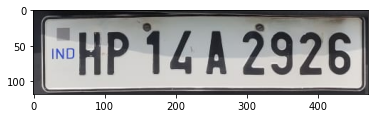

In [11]:
#test image is used for detecting plate
inputImg = cv2.imread('c3.jpeg')
inpImg, plate = plate_detect(inputImg)
display_img(inpImg)
display_img(plate)

## Functions for number plate digit segmentation

In [5]:
def find_contours(dimensions, img) :
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    ci = cv2.imread('contour.jpg')   
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detecting contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) 
            char_copy = np.zeros((44,24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            cv2.rectangle(ci, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ci, cmap='gray')
            char = cv2.subtract(255, char)
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            img_res.append(char_copy)                 
    plt.show()
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)
    return img_res

In [6]:
def segment_characters(image) :
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))
    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)
    char_list = find_contours(dimensions, img_binary_lp)
    return char_list

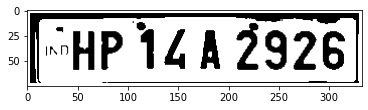

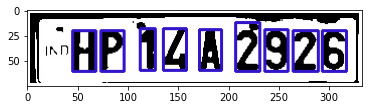

In [12]:
char = segment_characters(plate)

## Add Training and testing data for the model

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data/data/'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  
        target_size=(28,28), 
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  
        target_size=(28,28),  
        class_mode='sparse')

Found 866 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


## Create the model for character recognition

In [8]:
K.clear_session()
model = Sequential()
model.add(Conv2D(64, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (2,2), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

C:\Users\Abhinav\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [9]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98):
            self.model.stop_training = True

## Training Model for character recognition

In [10]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 45, verbose=1, callbacks=callbacks)

C:\Users\Abhinav\anaconda3\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/45
866/866 [==============================] - 32s 26ms/step - loss: 3.5732 - accuracy: 0.0375 - val_loss: 3.5314 - val_accuracy: 0.1111
Epoch 2/45
866/866 [==============================] - 23s 26ms/step - loss: 3.5023 - accuracy: 0.0755 - val_loss: 3.2882 - val_accuracy: 0.1713
Epoch 3/45
866/866 [==============================] - 22s 26ms/step - loss: 3.2063 - accuracy: 0.1292 - val_loss: 2.5999 - val_accuracy: 0.3519
Epoch 4/45
866/866 [==============================] - 23s 26ms/step - loss: 2.5683 - accuracy: 0.3198 - val_loss: 1.9607 - val_accuracy: 0.5741
Epoch 5/45
866/866 [==============================] - 23s 26ms/step - loss: 2.0188 - accuracy: 0.4025 - val_loss: 1.4909 - val_accuracy: 0.6389
Epoch 6/45
866/866 [==============================] - 23s 26ms/step - loss: 1.5897 - accuracy: 0.5299 - val_loss: 1.2099 - val_accuracy: 0.6991
Epoch 7/45
866/866 [==============================] - 23s 26ms/step - loss: 1.3591 - accuracy: 0.6041 - val_loss: 1.0486 - val_accuracy:

## Using model for character recognition

In [13]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): 
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y_ = model.predict_classes(img)[0]
        character = dic[y_] #
        output.append(character) 
        
    plate_number = ''.join(output)
    
    return plate_number

final_plate = show_results()
print(final_plate)

C:\Users\Abhinav\anaconda3\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


HP14A2926


In [ ]:
## Using API to check car details from the number plate

In [14]:
def get_vehicle_info(plate_number):
    r = requests.get("http://www.regcheck.org.uk/api/reg.asmx/CheckIndia?RegistrationNumber={0}&username=carres00".format(str(plate_number)))
    data = xmltodict.parse(r.content)
    jdata = json.dumps(data)
    df = json.loads(jdata)
    df1 = json.loads(df['Vehicle']['vehicleJson'])
    return df1


In [15]:
get_vehicle_info(final_plate)

{'Description': 'MARUTI SUZUKI ALTO LXI BS3',
 'RegistrationYear': '2006',
 'CarMake': {'CurrentTextValue': 'MARUTI SUZUKI'},
 'CarModel': {'CurrentTextValue': 'ALTO LXI BS3'},
 'Variant': 'LXi Petrol 796.0',
 'EngineSize': {'CurrentTextValue': '796.0'},
 'MakeDescription': {'CurrentTextValue': 'MARUTI SUZUKI'},
 'ModelDescription': {'CurrentTextValue': 'ALTO LXI BS3'},
 'NumberOfSeats': {'CurrentTextValue': '5'},
 'VechileIdentificationNumber': 'MA3EYD81SOO717888',
 'EngineNumber': 'F8DN3291316',
 'FuelType': {'CurrentTextValue': 'PETROL'},
 'RegistrationDate': '31/07/2006',
 'Owner': 'AVTAR CHAUDHARY',
 'Fitness': '',
 'Insurance': '2021-07-09',
 'PUCC': '',
 'VehicleType': 'MOTOR CAR(LMV)',
 'Location': 'RLA,SOLAN',
 'ImageUrl': 'http://www.carregistrationapi.in/image.aspx/@TUFSVVRJIFNVWlVLSSBBTFRPIExYSSBCUzM='}

## Save the model created

In [ ]:
model.save('license_plate_character_02.h5')

In [ ]:
# from tensorflow import keras
# model = keras.models.load_model("license_plate_character_02.h5")